Click this button to run in Colab.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ssuai/deep_learning_from_scratch/blob/master/ch04/train_neural_net.ipynb)

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# some helper functions for Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False
    
if is_colab():
    !git clone --filter=blob:none --sparse https://github.com/ssuai/deep_learning_from_scratch.git
    %cd deep_learning_from_scratch
    !git sparse-checkout set dataset common ch04
    !cp ch04/two_layer_net.py .

## 4.3.2 수치 미분의 예
$y = 0.01 x^2 + 0.1 x$

0.1999999999990898


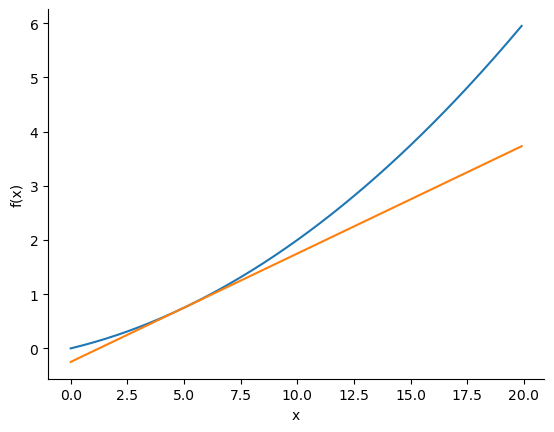

In [3]:
# gradient_1d.py
def function_1(x):
    return 0.01*x**2 + 0.1*x 


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
sns.despine()

## 4.4 기울기 (gradient)
$ f(x_0,x_1) = x_0^2 + x_1^2$

In [4]:
# gradient_2d.py
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

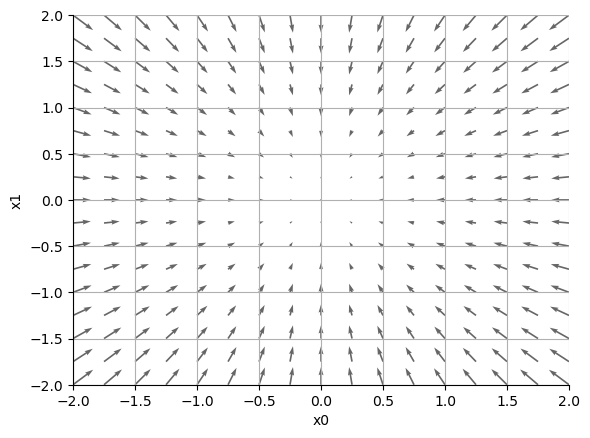

In [5]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
# plt.legend()
# plt.draw()
# plt.show()
sns.despine()

## 4.4.1 경사법 (경사 하강법)

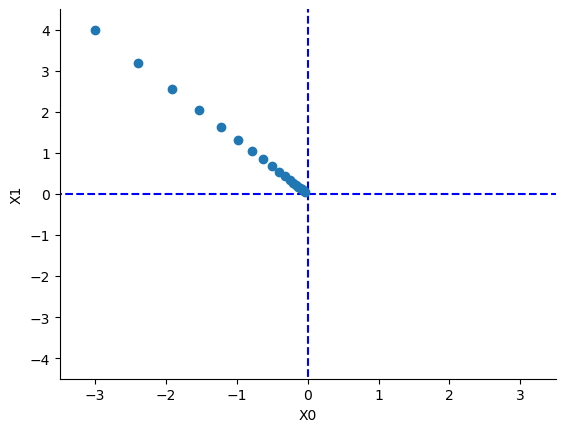

In [6]:
# gradient_method.py
# def function_2(x):
#     return x[0]**2 + x[1]**2

# from gradient_2d import numerical_gradient
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
sns.despine()

## 4.4.2 신경망에서의 기울기

In [7]:
# gradient_simplenet.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)    # w is dummy
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.24478326  0.30238018 -0.54716343]
 [ 0.36717489  0.45357027 -0.82074515]]


In [8]:
net.loss(x,t)

np.float64(2.429736794263038)

## 4.5.1 2층 신경망 클래스 구현하기

In [9]:
# two_layer_net.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [10]:
# 사용 예
net = TwoLayerNet(input_size=64, hidden_size=20, output_size=5)
net.params

{'W1': array([[-0.01563995, -0.01896731, -0.00266325, ...,  0.00606261,
         -0.01724541,  0.00092005],
        [ 0.00548945,  0.01110997,  0.014907  , ...,  0.01288959,
         -0.01505577, -0.00940498],
        [-0.00024843, -0.00303503,  0.00391016, ...,  0.00406775,
          0.00558922, -0.00560194],
        ...,
        [-0.00823725, -0.02570465, -0.01107749, ...,  0.01596581,
          0.03040868, -0.00470599],
        [ 0.0028168 ,  0.00212018, -0.01620175, ..., -0.00486906,
         -0.00131481, -0.00517377],
        [ 0.01158791, -0.00386181,  0.00571928, ...,  0.00147082,
          0.00472029, -0.00752763]]),
 'b1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'W2': array([[ 6.93212840e-03, -1.91053211e-02,  3.07484836e-04,
         -1.44325288e-02, -1.15771124e-02],
        [ 1.49167857e-02,  1.05806260e-02, -1.03727698e-02,
         -3.64019385e-03,  4.01261737e-03],
        [-3.37988359e-03, -1.89734410e-02, -1.480

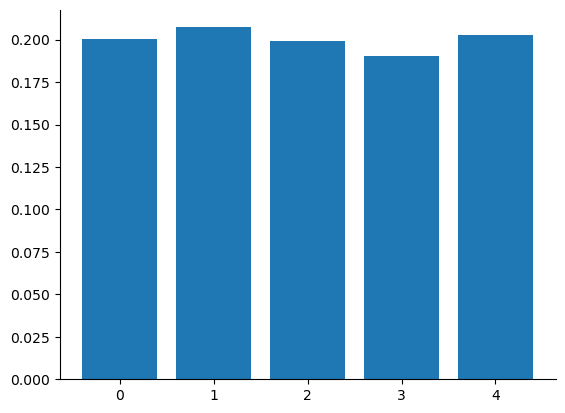

In [11]:
# forward prop
x = np.random.rand(100,64)
y = net.predict(x)

plt.bar(np.arange(0,5), y[0])
sns.despine()

In [12]:
%%time
# calc numerical gradient
t = np.random.rand(100,5)
numerical_grads = net.numerical_gradient(x, t)
numerical_grads

CPU times: user 340 ms, sys: 2.44 ms, total: 342 ms
Wall time: 117 ms


{'W1': array([[-2.87937435e-04, -3.23362359e-05, -6.52124033e-05, ...,
          6.16233919e-05,  1.18901935e-04,  5.08049924e-05],
        [-3.17200595e-04, -1.17883242e-04, -1.59717928e-05, ...,
         -3.12047876e-05,  8.76468476e-05, -1.60896352e-05],
        [-4.38275214e-04, -1.20144352e-04, -1.19594595e-04, ...,
          1.39042154e-04,  1.96214051e-04,  1.35081392e-04],
        ...,
        [-2.58476882e-04,  1.28432398e-05, -5.97061778e-05, ...,
          8.88284002e-05,  1.20875713e-04,  1.27368590e-04],
        [-4.36570842e-04, -1.35324250e-04, -1.83054503e-04, ...,
          1.68467957e-04,  2.09807506e-04,  3.76568554e-06],
        [-2.36675041e-04,  1.72062686e-05, -6.09461304e-05, ...,
          5.80673976e-05,  1.02655693e-04,  3.40858852e-05]]),
 'b1': array([-6.30406148e-04, -1.52302201e-04, -2.07006581e-04,  6.26540264e-05,
         1.27961662e-04, -3.75461942e-04, -3.24738871e-04,  3.92784039e-05,
         1.09341869e-06,  2.49622003e-04,  2.90852107e-04,  2.264

In [13]:
%%time
grads = net.gradient(x, t)
grads

CPU times: user 4.62 ms, sys: 1.17 ms, total: 5.8 ms
Wall time: 1.19 ms


{'W2': array([[-0.16449573, -0.14917123, -0.15934018, -0.13737282, -0.14298221],
        [-0.16208853, -0.14700542, -0.15714836, -0.13545117, -0.14070663],
        [-0.15872316, -0.14399871, -0.15426119, -0.13238832, -0.13811468],
        [-0.16841387, -0.15260427, -0.16338047, -0.14105045, -0.14608206],
        [-0.15642315, -0.14167004, -0.15144552, -0.1303631 , -0.13564944],
        [-0.1683485 , -0.15215436, -0.16300228, -0.14050656, -0.14612797],
        [-0.16383294, -0.14867426, -0.15923999, -0.13714144, -0.14237359],
        [-0.16192175, -0.14686509, -0.15710477, -0.13498531, -0.14039375],
        [-0.16027864, -0.14479607, -0.15491843, -0.13352938, -0.13878102],
        [-0.1658935 , -0.15024027, -0.16092964, -0.13827148, -0.14403397],
        [-0.16321648, -0.14767222, -0.15810971, -0.13590008, -0.14170759],
        [-0.16266892, -0.14751102, -0.15772747, -0.13588658, -0.14129215],
        [-0.16405893, -0.14837317, -0.15909202, -0.13702318, -0.14251444],
        [-0.1724632

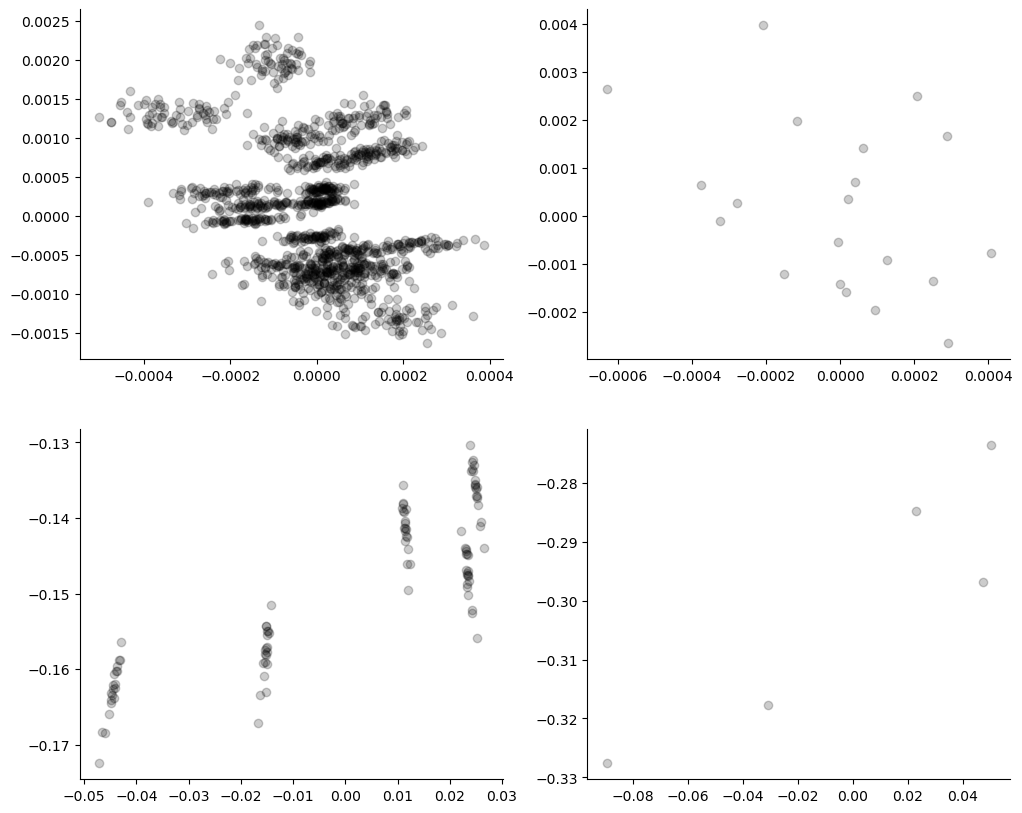

In [14]:
# 비교
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.scatter(numerical_grads['W1'], grads['W1'], alpha=0.2, c='k')
sns.despine()
plt.subplot(222)
plt.scatter(numerical_grads['b1'], grads['b1'], alpha=0.2, c='k')
sns.despine()
plt.subplot(223)
plt.scatter(numerical_grads['W2'], grads['W2'], alpha=0.2, c='k')
sns.despine()
plt.subplot(224)
plt.scatter(numerical_grads['b2'], grads['b2'], alpha=0.2, c='k')
sns.despine()

## MNIST 데이터로 학습 (4.5.2 미니배치 학습 구현하기 / 4.5.3 시험 데이터로 평가하기)

In [15]:
# train_neuralnet.py
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)   # TOO SLOW TO RUN
    grad = network.gradient(x_batch, t_batch)    # faster! (Next chapter)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09863333333333334, 0.0958
train acc, test acc | 0.7901, 0.792
train acc, test acc | 0.8769, 0.8796
train acc, test acc | 0.8991333333333333, 0.9012
train acc, test acc | 0.9077333333333333, 0.9107
train acc, test acc | 0.9135833333333333, 0.9167
train acc, test acc | 0.9194833333333333, 0.9209
train acc, test acc | 0.9237333333333333, 0.9254
train acc, test acc | 0.9262166666666667, 0.9286
train acc, test acc | 0.9304666666666667, 0.9316
train acc, test acc | 0.9335333333333333, 0.935
train acc, test acc | 0.9360833333333334, 0.9372
train acc, test acc | 0.9386666666666666, 0.9396
train acc, test acc | 0.9412166666666667, 0.9417
train acc, test acc | 0.9430166666666666, 0.9427
train acc, test acc | 0.9458166666666666, 0.9456
train acc, test acc | 0.9475666666666667, 0.9455


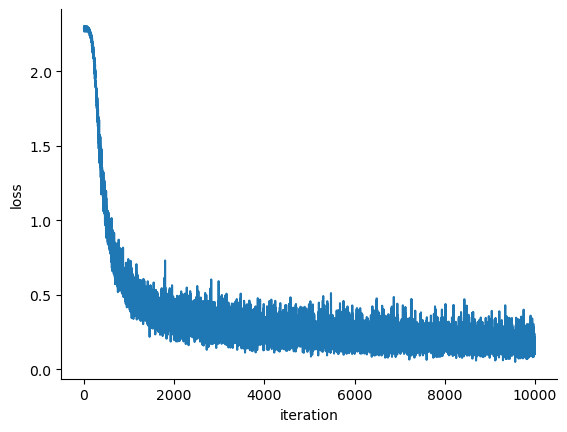

In [16]:
# 손실 함수
plt.plot(train_loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
sns.despine()

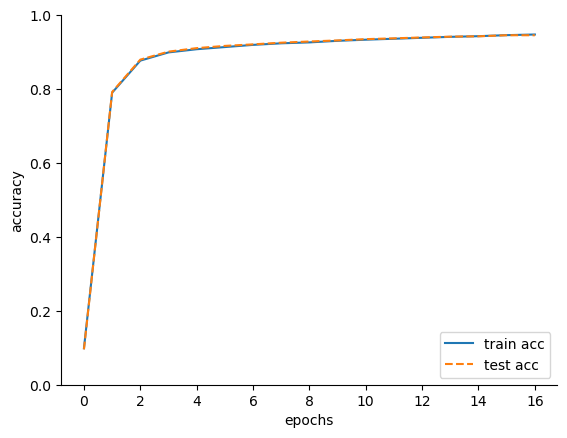

In [17]:
# 정확도 그래프
# markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
# plt.show()
sns.despine()